# Load GPS pings and tag based on each category of window


## Import Libraries

In [1]:
import pandas as pd
import datetime
import geopandas as gpd
import numpy as np
import plotly.express as px
import os
import json
import shapely
import matplotlib.pyplot as plt

## Setup File Path for Input and Process to Load in CSV Files

In [1]:
# load gps ping data
# see `Extract_360toCSV.ipynb` for details on getting pings from raw video data
# these data files are on SharePoint at:
# https://usdot.sharepoint.com/:f:/r/teams/volpe-proj-HW72B120-ebikePL/Shared%20Documents/General/FHWA%20GPS%20Data/new_video_output

# assumes data are all in a single folder (data_dir) with GPS named "Participant #_GPS5.csv" 
# and accel named "Participant #_ACCL.csv"

#set file path
data_dir = r"C:\Temp\ebike\new_csvs"

#create lists for csv files - gps and accel data
gps_csvs = []
acc_csvs = []

#loop through files to add to each appropriate list
for file in os.listdir(data_dir):
    if file[-8:] == 'GPS5.csv':
        gps_csvs.append(os.path.join(data_dir,file))
    if file[-8:] == 'ACCL.csv':
        acc_csvs.append(os.path.join(data_dir,file))

#concatenate csv files into one dataframe for gps and accel data
gps_df = pd.concat((pd.read_csv(f).assign(participant = f.split("\\")[-1].split("_")[0]) for f in gps_csvs), ignore_index=True)

acc_df = pd.concat((pd.read_csv(f).assign(participant = f.split("\\")[-1].split("_")[0]) for f in acc_csvs), ignore_index=True)


NameError: name 'os' is not defined

# Data Cleaning and Processing

In [3]:
# clean up 

#change varible data types - gps dataframe
gps_df["ParticipantID"] = pd.to_numeric(gps_df["participant"].str.strip("Participant "))
gps_df["timestamp"] = pd.to_datetime(gps_df["date"])

#rename column titles
gps_df = gps_df.rename(columns = {"GPS (Lat.) [deg]": "lat", 
                                  "GPS (Long.) [deg]": "lon", 
                                  "GPS (3D speed) [m/s]": "spd"})


#change varible data types - accel dataframe
acc_df["ParticipantID"] = pd.to_numeric(acc_df["participant"].str.strip("Participant "))
acc_df["timestamp"] = pd.to_datetime(acc_df["date"])

#rename column titles
acc_df = acc_df.rename(columns = {"Accelerometer (y) [m/s2]": "acc_long"}) # y is longitudinal direction but we don't know if it's fwd or backwards

In [ ]:
pd.set_option('display.max_columns', None)

In [4]:
gps_df

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,participant,ParticipantID,timestamp
0,1.587878e+06,2022-05-20T23:35:01.110Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.110000+00:00
1,1.587957e+06,2022-05-20T23:35:01.192Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.192000+00:00
2,1.588062e+06,2022-05-20T23:35:01.302Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.302000+00:00
3,1.588167e+06,2022-05-20T23:35:01.412Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.412000+00:00
4,1.588273e+06,2022-05-20T23:35:01.522Z,42.455242,-71.313907,64.143000,7.4390,3.72,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.522000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497133,2.028361e+05,2022-05-01T19:23:09.751Z,42.397660,-71.143449,-2.285984,0.0365,0.05,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:09.751000+00:00
497134,2.029539e+05,2022-05-01T19:23:09.867Z,42.397660,-71.143449,-2.182984,0.0330,0.04,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:09.867000+00:00
497135,2.030422e+05,2022-05-01T19:23:09.955Z,42.397660,-71.143449,-2.108484,0.0560,0.05,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:09.955000+00:00
497136,2.031305e+05,2022-05-01T19:23:10.042Z,42.397659,-71.143449,-2.055984,0.0490,0.07,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:10.042000+00:00


In [5]:
# play with this to get right timestamp to filter out bad data

gps_df[gps_df["timestamp"] > pd.Timestamp(year=2022,
                                          month=4,
                                          day=1, 
                                          tz="utc")].groupby("ParticipantID")["timestamp"].agg([min, max])

,min,max
ParticipantID,,
1,2022-04-29 19:53:16.363000+00:00,2022-04-29 21:00:56.389000+00:00
2,2022-04-29 19:57:17.069000+00:00,2022-04-29 21:01:00.175000+00:00
3,2022-04-27 23:46:03.618000+00:00,2022-04-27 23:59:27.230000+00:00
4,2022-04-27 23:42:29.834000+00:00,2022-04-27 23:54:07.375000+00:00
5,2022-05-15 19:48:38.691000+00:00,2022-05-15 21:31:31.259000+00:00
6,2022-05-08 17:14:46.119000+00:00,2022-05-08 17:34:04.115000+00:00
7,2022-05-17 20:45:17.930000+00:00,2022-05-17 21:47:50.689000+00:00
8,2022-05-17 21:15:12.360000+00:00,2022-05-17 21:47:24.070000+00:00
9,2022-05-01 19:19:53.479000+00:00,2022-05-01 19:23:10.129000+00:00


In [6]:
# more cleaning
# remove points with bad timestamps
gps_df = gps_df[gps_df["timestamp"] > pd.Timestamp(year=2022,
                                                   month=4,
                                                   day=1, 
                                                   tz="utc")]
gps_df

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,participant,ParticipantID,timestamp
0,1.587878e+06,2022-05-20T23:35:01.110Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.110000+00:00
1,1.587957e+06,2022-05-20T23:35:01.192Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.192000+00:00
2,1.588062e+06,2022-05-20T23:35:01.302Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.302000+00:00
3,1.588167e+06,2022-05-20T23:35:01.412Z,42.455146,-71.314113,63.427000,0.0000,0.00,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.412000+00:00
4,1.588273e+06,2022-05-20T23:35:01.522Z,42.455242,-71.313907,64.143000,7.4390,3.72,2,199.0,MSLV,Participant 10,10,2022-05-20 23:35:01.522000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497133,2.028361e+05,2022-05-01T19:23:09.751Z,42.397660,-71.143449,-2.285984,0.0365,0.05,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:09.751000+00:00
497134,2.029539e+05,2022-05-01T19:23:09.867Z,42.397660,-71.143449,-2.182984,0.0330,0.04,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:09.867000+00:00
497135,2.030422e+05,2022-05-01T19:23:09.955Z,42.397660,-71.143449,-2.108484,0.0560,0.05,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:09.955000+00:00
497136,2.031305e+05,2022-05-01T19:23:10.042Z,42.397659,-71.143449,-2.055984,0.0490,0.07,3,178.0,NaN,Participant 9,9,2022-05-01 19:23:10.042000+00:00


In [7]:
# remove points with bad locations
gps_gdf = gpd.GeoDataFrame(gps_df, 
                           geometry=gpd.points_from_xy(gps_df["lon"],
                                                       gps_df["lat"], 
                                                       crs=4326))
gps_gdf = gps_gdf.to_crs(32619)  # UTM 19N - for Eastern Mass.

trail_path = r"C:\temp\ebike\OSM_BattleRoadTrail.shp"
trail_gdf = gpd.read_file(trail_path)
trail_gdf = trail_gdf.to_crs(32619)

trail_buffer = trail_gdf.unary_union.buffer(15) #was 40 ft for polygons, rounding to 15m for point filter

gps_gdf = gps_gdf.clip(trail_buffer)
gps_gdf

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,participant,ParticipantID,timestamp,geometry
215001,2.515446e+06,2022-07-01T19:03:01.787Z,42.447597,-71.256333,65.165623,2.1160,2.145,3,147.0,NaN,Participant 24,24,2022-07-01 19:03:01.787000+00:00,POINT (314446.728 4701940.857)
295422,2.629735e+06,2022-07-16T14:25:26.171Z,42.447578,-71.256410,60.439046,2.3100,2.360,3,443.0,NaN,Participant 28,28,2022-07-16 14:25:26.171000+00:00,POINT (314440.388 4701938.886)
295421,2.629646e+06,2022-07-16T14:25:26.078Z,42.447579,-71.256409,60.339046,2.3900,2.435,3,443.0,NaN,Participant 28,28,2022-07-16 14:25:26.078000+00:00,POINT (314440.430 4701939.074)
295420,2.629558e+06,2022-07-16T14:25:25.986Z,42.447581,-71.256408,60.407046,2.4090,2.140,3,443.0,NaN,Participant 28,28,2022-07-16 14:25:25.986000+00:00,POINT (314440.529 4701939.238)
295419,2.629470e+06,2022-07-16T14:25:25.894Z,42.447582,-71.256406,60.637546,2.1535,2.230,3,443.0,NaN,Participant 28,28,2022-07-16 14:25:25.894000+00:00,POINT (314440.744 4701939.427)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474156,1.877061e+06,2022-05-17T21:18:06.220Z,42.448701,-71.257258,54.281098,3.6700,3.680,3,205.0,NaN,Participant 7,7,2022-05-17 21:18:06.220000+00:00,POINT (314373.951 4702065.501)
474158,1.878437e+06,2022-05-17T21:18:06.874Z,42.448719,-71.257267,54.331098,3.7660,4.710,3,205.0,NaN,Participant 7,7,2022-05-17 21:18:06.874000+00:00,POINT (314373.287 4702067.475)
474159,1.878687e+06,2022-05-17T21:18:07.259Z,42.448726,-71.257267,54.393098,3.7240,3.740,3,205.0,NaN,Participant 7,7,2022-05-17 21:18:07.259000+00:00,POINT (314373.325 4702068.274)
474157,1.878187e+06,2022-05-17T21:18:06.489Z,42.448816,-71.257292,50.974098,4.7030,4.560,3,205.0,NaN,Participant 7,7,2022-05-17 21:18:06.489000+00:00,POINT (314371.460 4702078.313)


## Setup Polygon Windows/Segments

In [8]:
# this is most recent polygon file from SharePoint
# https://usdot.sharepoint.com/:u:/r/teams/volpe-proj-HW72B120-ebikePL/Shared%20Documents/General/Jonah%20Bike%20GPS%20Data/Polygons/Time_Windows_Nov21.zip
polygons = gpd.read_file(r"C:\Temp\ebike\new_new_polygons\TIME_WINDOWS.shp", crs=4236)
polygons = polygons.to_crs(32619) # UTM 19N - for Eastern Mass.

# this is on sharepoint as well:
# https://usdot.sharepoint.com/:u:/r/teams/volpe-proj-HW72B120-ebikePL/Shared%20Documents/General/Jonah%20Bike%20GPS%20Data/GIS%20for%20Jonah/ebike_slope_polygons.shp
slope_polygons = gpd.read_file(r"C:\Temp\ebike\ebike_slope_polygons.shp")
slope_polygons["Window"] = slope_polygons.index + 90
slope_polygons["FIRST_cate"] = np.where(slope_polygons["Uphill_Dir"] == "westbound", 
                                        "Uphill (westbound)", 
                                        "Uphill (eastbound)")
polygons = pd.concat([polygons, slope_polygons[["Window","FIRST_cate", "geometry"]]])

In [9]:
# we decided we only need the category labels, not which specific window they fall in
polygon_cats = polygons.dissolve("FIRST_cate")
polygon_cats

,geometry,Window,SUM_Shape_,RANGE_Elap,FIRST_Sour,MIN_DateTi,Shape_Leng,Shape_Area
FIRST_cate,,,,,,,,
Blind Turn,"MULTIPOLYGON (((310483.556 4702680.754, 310481...",10,0.005794,4.0,GS020241.360,2021-11-16,0.001377,1.161174e-07
Constrained Tunnel,"POLYGON ((312032.112 4702141.078, 312023.576 4...",31,0.010570,9.0,GS030241.360,2021-11-16,0.001511,1.275870e-07
Narrow,"MULTIPOLYGON (((312616.423 4702174.685, 312614...",16,0.006656,6.0,GS020241.360,2021-11-16,0.001098,8.175704e-08
Slow Sign (EB),"POLYGON ((312012.694 4702166.882, 312020.944 4...",30,0.017381,17.0,GS030241.360,2021-11-16,0.002798,2.823206e-07
Slow Sign (WB),"POLYGON ((311085.998 4702969.196, 311084.672 4...",23,0.003914,3.0,GS020241.360,2021-11-16,0.001213,9.530095e-08
Trail Hazards,"MULTIPOLYGON (((313746.800 4701952.924, 313748...",14,0.026934,25.0,GS020241.360,2021-11-16,0.003688,3.754687e-07
Trail Junction,"MULTIPOLYGON (((313475.659 4702131.278, 313471...",13,0.002742,1.0,GS020241.360,2021-11-16,0.000999,7.130713e-08
Uphill (eastbound),"MULTIPOLYGON (((312771.123 4702136.018, 312769...",91,NaN,NaN,None,None,NaN,NaN
Uphill (westbound),"MULTIPOLYGON (((313542.949 4702054.297, 313541...",90,NaN,NaN,None,None,NaN,NaN


## Calculate Distance of Pings from Windows/Segments

In [10]:
dist_matrix = gps_gdf.apply(lambda x: polygon_cats.distance(x.geometry), axis=1)
dist_matrix

FIRST_cate,Blind Turn,Constrained Tunnel,Narrow,Slow Sign (EB),Slow Sign (WB),Trail Hazards,Trail Junction,Uphill (eastbound),Uphill (westbound),Vehicle Conflict Point,Walk Bike Sign (WB),Wide Downhill (EB)
215001,170.812497,2388.239458,1811.808100,2418.518263,3513.214786,322.312046,974.487166,1650.420747,893.852524,36.854123,4774.497091,1455.368181
295422,169.689714,2382.102790,1805.830441,2412.376025,3507.736261,318.528902,968.699861,1644.392384,887.868869,32.813678,4768.704348,1449.627337
295421,169.539181,2382.127632,1805.844010,2412.401289,3507.721023,318.444980,968.701358,1644.409376,887.882691,32.735690,4768.706410,1449.626216
295420,169.435040,2382.211382,1805.917477,2412.485420,3507.767241,318.420544,968.763592,1644.485990,887.956409,32.717619,4768.769147,1449.685966
295419,169.359784,2382.408311,1806.101871,2412.682807,3507.916909,318.471726,968.933949,1644.674260,888.141139,32.777967,4768.940102,1449.853150
...,...,...,...,...,...,...,...,...,...,...,...,...
474156,26.945401,2307.588873,1725.046230,2338.096126,3408.361179,195.552447,883.829834,1566.200638,811.547645,20.145226,4678.683428,1360.832445
474158,24.867558,2306.850344,1724.220444,2337.360717,3407.194933,194.179346,882.991807,1565.425158,810.869442,22.155250,4677.666862,1359.889719
474159,24.145188,2306.857927,1724.192003,2337.369576,3407.018238,193.910522,882.958836,1565.417722,810.902556,22.950583,4677.556560,1359.811902
474157,14.193439,2304.639830,1721.534862,2335.167082,3402.558055,188.582569,880.274848,1563.023739,809.047463,33.084782,4673.883065,1356.557609


## Create Dataframe of Pings Coded for Windows/Segments

In [11]:
# change from distances to yes/no flags for each category; if in the window (dist=0), flag=1, else flag=0
cols_to_add = pd.DataFrame(np.where(dist_matrix == 0, 1, 0), index=dist_matrix.index, columns=dist_matrix.columns)
cols_to_add

FIRST_cate,Blind Turn,Constrained Tunnel,Narrow,Slow Sign (EB),Slow Sign (WB),Trail Hazards,Trail Junction,Uphill (eastbound),Uphill (westbound),Vehicle Conflict Point,Walk Bike Sign (WB),Wide Downhill (EB)
215001,0,0,0,0,0,0,0,0,0,0,0,0
295422,0,0,0,0,0,0,0,0,0,0,0,0
295421,0,0,0,0,0,0,0,0,0,0,0,0
295420,0,0,0,0,0,0,0,0,0,0,0,0
295419,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
474156,0,0,0,0,0,0,0,0,0,0,0,0
474158,0,0,0,0,0,0,0,0,0,0,0,0
474159,0,0,0,0,0,0,0,0,0,0,0,0
474157,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
gps_gdf = gps_gdf.merge(cols_to_add, left_index=True, right_index=True)

In [13]:
gps_gdf.sort_index()

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,...,Narrow,Slow Sign (EB),Slow Sign (WB),Trail Hazards,Trail Junction,Uphill (eastbound),Uphill (westbound),Vehicle Conflict Point,Walk Bike Sign (WB),Wide Downhill (EB)
71,2.554769e+04,2022-06-06T23:26:29.512Z,42.447818,-71.256805,71.717811,0.1345,0.120,3,207.0,NaN,...,0,0,0,0,0,0,0,1,0,0
72,2.565305e+04,2022-06-06T23:26:29.703Z,42.447818,-71.256805,71.718811,0.0745,0.145,3,207.0,NaN,...,0,0,0,0,0,0,0,1,0,0
73,2.575842e+04,2022-06-06T23:26:29.894Z,42.447818,-71.256805,71.712311,0.0600,0.035,3,207.0,NaN,...,0,0,0,0,0,0,0,1,0,0
74,2.586379e+04,2022-06-06T23:26:30.085Z,42.447818,-71.256805,71.705811,0.0330,0.055,3,207.0,NaN,...,0,0,0,0,0,0,0,1,0,0
75,2.596916e+04,2022-06-06T23:26:30.276Z,42.447818,-71.256805,71.699811,0.0185,0.020,3,207.0,NaN,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495188,3.573433e+06,2022-05-17T21:47:15.027Z,42.459798,-71.323976,30.676541,4.4195,4.455,3,148.0,NaN,...,0,0,0,0,0,0,0,0,0,0
495189,3.573544e+06,2022-05-17T21:47:15.136Z,42.459801,-71.323972,30.690041,4.3980,4.400,3,148.0,NaN,...,0,0,0,0,0,0,0,0,0,0
495190,3.573656e+06,2022-05-17T21:47:15.245Z,42.459804,-71.323968,30.698541,4.5115,4.500,3,148.0,NaN,...,0,0,0,0,0,0,0,0,0,0
495191,3.573767e+06,2022-05-17T21:47:15.355Z,42.459807,-71.323964,30.771041,4.3100,4.390,3,148.0,NaN,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

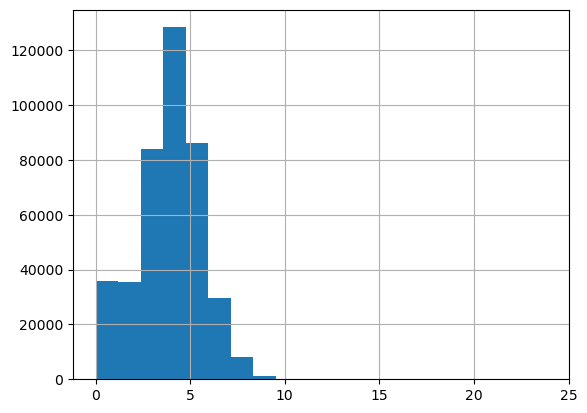

In [14]:
gps_gdf["spd"].hist(bins=20)

In [ ]:
gps_gdf[["lat", "lon", "spd", "date", 'ParticipantID', 'Blind Turn',
       'Constrained Tunnel', 'Narrow', 'Slow Sign (EB)', 'Slow Sign (WB)',
       'Trail Hazards', 'Trail Junction', 'Uphill (eastbound)',
       'Uphill (westbound)', 'Vehicle Conflict Point', 'Walk Bike Sign (WB)',
       'Wide Downhill (EB)']].sort_values(["ParticipantID", "date"]).to_csv("data/Pings_Tagged_2023-07-07.csv", index=False)

outputs uploaded here: https://usdot.sharepoint.com/:x:/r/teams/volpe-proj-HW72B120-ebikePL/Shared%20Documents/General/FHWA%20GPS%20Data/Pings_Tagged_2023-03-20.csv

to-do (for Kirby): 
* add direction (eastbound/westbound) to all pings - DONE
* update "Uphill (eastbound)" and "Uphill (westbound)" categories to be "Uphill" and "Downhill" based on ping direction
    * uphill EB = downhill WB and vice versa - DONE
* update other EB and WB categories (these are simpler -- just drop the wrong-direction pings) - DONE, reassigned value of 0 where direction didn't match
* decide whether to keep categories we dropped last time for lack of data (Constrained Tunnel, Slow Sign, Walk Bike Sign, Wide Downhill) - DONE, dropped Wide Downhill

In [5]:
# Upload output file from above if not re-running code
# May need to copy file to data_dir below
data_dir = r"C:\Temp\ebike"
gps_gdf = pd.read_csv("data/Pings_Tagged_2023-03-20.csv")
gps_gdf.head()

In [15]:
gps_gdf = gps_gdf.sort_values("date").reset_index(drop=True)

In [16]:
# Rename Uphill columns and create corresponding Downhill columns
gps_gdf = gps_gdf.rename(columns = {'Uphill (eastbound)': 'Uphill (EB)', 'Uphill (westbound)': 'Uphill (WB)'})
gps_gdf['Downhill (WB)'] = gps_gdf['Uphill (EB)']
gps_gdf['Downhill (EB)'] = gps_gdf['Uphill (WB)']
gps_gdf

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,...,Slow Sign (WB),Trail Hazards,Trail Junction,Uphill (EB),Uphill (WB),Vehicle Conflict Point,Walk Bike Sign (WB),Wide Downhill (EB),Downhill (WB),Downhill (EB)
0,1.051038e+06,2022-04-27T23:42:29.834Z,42.459184,-71.313876,58.706562,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.051149e+06,2022-04-27T23:42:29.938Z,42.459187,-71.313881,58.707562,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.051261e+06,2022-04-27T23:42:30.042Z,42.459189,-71.313887,58.708062,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1.051372e+06,2022-04-27T23:42:30.146Z,42.459192,-71.313892,58.709062,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1.051455e+06,2022-04-27T23:42:30.224Z,42.459193,-71.313898,61.802062,4.9330,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,3.789637e+06,2022-09-23T18:31:05.106Z,42.447985,-71.256852,70.146000,1.3295,1.305,3,477.0,MSLV,...,0,0,0,0,0,0,0,0,0,0
408359,3.789755e+06,2022-09-23T18:31:05.222Z,42.447987,-71.256851,70.191500,1.3630,1.355,3,477.0,MSLV,...,0,0,0,0,0,0,0,0,0,0
408360,3.789869e+06,2022-09-23T18:31:05.337Z,42.447989,-71.256850,70.266000,1.3845,1.375,3,460.0,MSLV,...,0,0,0,0,0,0,0,0,0,0
408361,3.789948e+06,2022-09-23T18:31:05.420Z,42.447989,-71.256849,70.330000,1.3910,1.390,3,460.0,MSLV,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dirs = gps_gdf[['lon','date','ParticipantID']]
dirs # = dirs.sort_values("date").reset_index(drop=True)

,lon,date,ParticipantID
0,-71.313876,2022-04-27T23:42:29.834Z,4
1,-71.313881,2022-04-27T23:42:29.938Z,4
2,-71.313887,2022-04-27T23:42:30.042Z,4
3,-71.313892,2022-04-27T23:42:30.146Z,4
4,-71.313898,2022-04-27T23:42:30.224Z,4
...,...,...,...
408358,-71.256852,2022-09-23T18:31:05.106Z,37
408359,-71.256851,2022-09-23T18:31:05.222Z,37
408360,-71.256850,2022-09-23T18:31:05.337Z,37
408361,-71.256849,2022-09-23T18:31:05.420Z,37


In [18]:
# Get first ping of ride --> starting point for each participant
first_ping = dirs.groupby('ParticipantID')['date'].min().reset_index()
first_ping = first_ping.merge(dirs, right_on = ['ParticipantID','date'], left_on = ['ParticipantID','date'], how = 'left')
first_ping.columns = ['ParticipantID','first_date','first_lon']
first_ping

,ParticipantID,first_date,first_lon
0,1,2022-04-29T19:53:16.363Z,-71.269125
1,2,2022-04-29T19:57:17.069Z,-71.278368
2,3,2022-04-27T23:46:03.618Z,-71.324160
3,4,2022-04-27T23:42:29.834Z,-71.313876
4,5,2022-05-15T19:50:02.511Z,-71.268292
5,6,2022-05-08T17:14:47.368Z,-71.293404
6,7,2022-05-17T20:45:25.135Z,-71.323983
7,8,2022-05-17T21:15:12.360Z,-71.258419
8,12,2022-06-06T23:26:29.512Z,-71.256805
9,14,2022-06-12T13:45:02.500Z,-71.287010


In [19]:
# Get last ping
last_ping = dirs.groupby('ParticipantID')['date'].max().reset_index()
last_ping = last_ping.merge(dirs, right_on = ['ParticipantID','date'], left_on = ['ParticipantID','date'], how = 'left').drop_duplicates(subset="ParticipantID",keep='last')
last_ping.columns = ['ParticipantID','last_date','last_lon']
last_ping = last_ping.reset_index(drop=True)
last_ping

,ParticipantID,last_date,last_lon
0,1,2022-04-29T21:00:56.389Z,-71.256721
1,2,2022-04-29T21:01:00.175Z,-71.256730
2,3,2022-04-27T23:59:27.230Z,-71.292392
3,4,2022-04-27T23:54:07.375Z,-71.306132
4,5,2022-05-15T21:31:31.259Z,-71.256520
5,6,2022-05-08T17:34:04.115Z,-71.256924
6,7,2022-05-17T21:47:09.274Z,-71.324075
7,8,2022-05-17T21:47:15.437Z,-71.323961
8,12,2022-06-07T00:23:22.748Z,-71.264169
9,14,2022-06-12T14:26:20.389Z,-71.264096


In [20]:
# Get extreme east ping for each participant
east_ping = dirs.groupby('ParticipantID')['lon'].max().reset_index()
east_ping = east_ping.merge(dirs, right_on = ['ParticipantID','lon'], left_on = ['ParticipantID','lon'], how = 'left')

# Some duplicates because not always moving at extreme point
# Keep just one entry per participant, e.g., with the max date
east_ping = east_ping.groupby(['ParticipantID','lon'])['date'].max().reset_index()
east_ping.columns = ['ParticipantID','east_lon','east_date']
east_ping

,ParticipantID,east_lon,east_date
0,1,-71.256721,2022-04-29T21:00:56.389Z
1,2,-71.256730,2022-04-29T21:01:00.175Z
2,3,-71.292392,2022-04-27T23:59:27.230Z
3,4,-71.306132,2022-04-27T23:54:07.375Z
4,5,-71.256518,2022-05-15T21:31:30.049Z
5,6,-71.256920,2022-05-08T17:34:03.867Z
6,7,-71.256410,2022-05-17T21:17:13.271Z
7,8,-71.257242,2022-05-17T21:17:59.340Z
8,12,-71.256799,2022-06-06T23:26:36.013Z
9,14,-71.264096,2022-06-12T14:26:20.389Z


In [21]:
# Similarly, get one extreme west ping for each participant
west_ping = dirs.groupby('ParticipantID')['lon'].min().reset_index()
west_ping = west_ping.merge(dirs, right_on = ['ParticipantID','lon'], left_on = ['ParticipantID','lon'], how = 'left')
west_ping = west_ping.groupby(['ParticipantID','lon'])['date'].max().reset_index()
west_ping.columns = ['ParticipantID','west_lon','west_date']
west_ping

,ParticipantID,west_lon,west_date
0,1,-71.324355,2022-04-29T20:20:11.876Z
1,2,-71.324350,2022-04-29T20:20:14.873Z
2,3,-71.324160,2022-04-27T23:46:03.618Z
3,4,-71.323938,2022-04-27T23:45:45.860Z
4,5,-71.324367,2022-05-15T20:45:27.041Z
5,6,-71.293404,2022-05-08T17:14:47.368Z
6,7,-71.324354,2022-05-17T20:45:37.372Z
7,8,-71.324126,2022-05-17T21:47:09.467Z
8,12,-71.321822,2022-06-07T00:00:41.629Z
9,14,-71.324391,2022-06-12T14:02:13.697Z


In [22]:
# Combine into one dataframe
combined_extremes = first_ping.merge(last_ping).merge(west_ping).merge(east_ping)
combined_extremes

,ParticipantID,first_date,first_lon,last_date,last_lon,west_lon,west_date,east_lon,east_date
0,1,2022-04-29T19:53:16.363Z,-71.269125,2022-04-29T21:00:56.389Z,-71.256721,-71.324355,2022-04-29T20:20:11.876Z,-71.256721,2022-04-29T21:00:56.389Z
1,2,2022-04-29T19:57:17.069Z,-71.278368,2022-04-29T21:01:00.175Z,-71.256730,-71.324350,2022-04-29T20:20:14.873Z,-71.256730,2022-04-29T21:01:00.175Z
2,3,2022-04-27T23:46:03.618Z,-71.324160,2022-04-27T23:59:27.230Z,-71.292392,-71.324160,2022-04-27T23:46:03.618Z,-71.292392,2022-04-27T23:59:27.230Z
3,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z
4,5,2022-05-15T19:50:02.511Z,-71.268292,2022-05-15T21:31:31.259Z,-71.256520,-71.324367,2022-05-15T20:45:27.041Z,-71.256518,2022-05-15T21:31:30.049Z
5,6,2022-05-08T17:14:47.368Z,-71.293404,2022-05-08T17:34:04.115Z,-71.256924,-71.293404,2022-05-08T17:14:47.368Z,-71.256920,2022-05-08T17:34:03.867Z
6,7,2022-05-17T20:45:25.135Z,-71.323983,2022-05-17T21:47:09.274Z,-71.324075,-71.324354,2022-05-17T20:45:37.372Z,-71.256410,2022-05-17T21:17:13.271Z
7,8,2022-05-17T21:15:12.360Z,-71.258419,2022-05-17T21:47:15.437Z,-71.323961,-71.324126,2022-05-17T21:47:09.467Z,-71.257242,2022-05-17T21:17:59.340Z
8,12,2022-06-06T23:26:29.512Z,-71.256805,2022-06-07T00:23:22.748Z,-71.264169,-71.321822,2022-06-07T00:00:41.629Z,-71.256799,2022-06-06T23:26:36.013Z
9,14,2022-06-12T13:45:02.500Z,-71.287010,2022-06-12T14:26:20.389Z,-71.264096,-71.324391,2022-06-12T14:02:13.697Z,-71.264096,2022-06-12T14:26:20.389Z


In [23]:
# Find mid point
combined_extremes['mid_lon'] = (combined_extremes['west_lon'] + combined_extremes['east_lon']) / 2
combined_extremes

,ParticipantID,first_date,first_lon,last_date,last_lon,west_lon,west_date,east_lon,east_date,mid_lon
0,1,2022-04-29T19:53:16.363Z,-71.269125,2022-04-29T21:00:56.389Z,-71.256721,-71.324355,2022-04-29T20:20:11.876Z,-71.256721,2022-04-29T21:00:56.389Z,-71.290538
1,2,2022-04-29T19:57:17.069Z,-71.278368,2022-04-29T21:01:00.175Z,-71.256730,-71.324350,2022-04-29T20:20:14.873Z,-71.256730,2022-04-29T21:01:00.175Z,-71.290540
2,3,2022-04-27T23:46:03.618Z,-71.324160,2022-04-27T23:59:27.230Z,-71.292392,-71.324160,2022-04-27T23:46:03.618Z,-71.292392,2022-04-27T23:59:27.230Z,-71.308276
3,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035
4,5,2022-05-15T19:50:02.511Z,-71.268292,2022-05-15T21:31:31.259Z,-71.256520,-71.324367,2022-05-15T20:45:27.041Z,-71.256518,2022-05-15T21:31:30.049Z,-71.290442
5,6,2022-05-08T17:14:47.368Z,-71.293404,2022-05-08T17:34:04.115Z,-71.256924,-71.293404,2022-05-08T17:14:47.368Z,-71.256920,2022-05-08T17:34:03.867Z,-71.275162
6,7,2022-05-17T20:45:25.135Z,-71.323983,2022-05-17T21:47:09.274Z,-71.324075,-71.324354,2022-05-17T20:45:37.372Z,-71.256410,2022-05-17T21:17:13.271Z,-71.290382
7,8,2022-05-17T21:15:12.360Z,-71.258419,2022-05-17T21:47:15.437Z,-71.323961,-71.324126,2022-05-17T21:47:09.467Z,-71.257242,2022-05-17T21:17:59.340Z,-71.290684
8,12,2022-06-06T23:26:29.512Z,-71.256805,2022-06-07T00:23:22.748Z,-71.264169,-71.321822,2022-06-07T00:00:41.629Z,-71.256799,2022-06-06T23:26:36.013Z,-71.289311
9,14,2022-06-12T13:45:02.500Z,-71.287010,2022-06-12T14:26:20.389Z,-71.264096,-71.324391,2022-06-12T14:02:13.697Z,-71.264096,2022-06-12T14:26:20.389Z,-71.294243


In [24]:
# It's possible that the extreme points are the first or last ping. Not exclusively midpoints.
# There are several scenarios
# Out and back with east turnaround
# Out and back with west turnaround
# One way (for some reason), east bound
# One way (for some reason), west bound
# Check for each one, noting that a higher lon is less negative and therefore more east

combined_extremes['Turnaround'] = None
for i in combined_extremes.index:
    if (combined_extremes.loc[i,"first_lon"] < combined_extremes.loc[i,"mid_lon"]) and (combined_extremes.loc[i,"last_lon"] < combined_extremes.loc[i,"mid_lon"]):
        # out and back with east turnaround
        combined_extremes.loc[i,'Turnaround'] = 'East Turnaround'
    elif (combined_extremes.loc[i,"first_lon"] > combined_extremes.loc[i,"mid_lon"]) and (combined_extremes.loc[i,"last_lon"] > combined_extremes.loc[i,"mid_lon"]):
        # out and back with west turnaround
        combined_extremes.loc[i,'Turnaround'] = 'West Turnaround'
    elif (combined_extremes.loc[i,"first_lon"] < combined_extremes.loc[i,"mid_lon"]) and (combined_extremes.loc[i,"last_lon"] > combined_extremes.loc[i,"mid_lon"]):
        # one way, east bound
        combined_extremes.loc[i,'Turnaround'] = 'One-Way Eastbound'
    elif (combined_extremes.loc[i,"first_lon"] > combined_extremes.loc[i,"mid_lon"]) and (combined_extremes.loc[i,"last_lon"] < combined_extremes.loc[i,"mid_lon"]):
        # one way, east bound
        combined_extremes.loc[i,'Turnaround'] = 'One-Way Westbound'

combined_extremes

,ParticipantID,first_date,first_lon,last_date,last_lon,west_lon,west_date,east_lon,east_date,mid_lon,Turnaround
0,1,2022-04-29T19:53:16.363Z,-71.269125,2022-04-29T21:00:56.389Z,-71.256721,-71.324355,2022-04-29T20:20:11.876Z,-71.256721,2022-04-29T21:00:56.389Z,-71.290538,West Turnaround
1,2,2022-04-29T19:57:17.069Z,-71.278368,2022-04-29T21:01:00.175Z,-71.256730,-71.324350,2022-04-29T20:20:14.873Z,-71.256730,2022-04-29T21:01:00.175Z,-71.290540,West Turnaround
2,3,2022-04-27T23:46:03.618Z,-71.324160,2022-04-27T23:59:27.230Z,-71.292392,-71.324160,2022-04-27T23:46:03.618Z,-71.292392,2022-04-27T23:59:27.230Z,-71.308276,One-Way Eastbound
3,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround
4,5,2022-05-15T19:50:02.511Z,-71.268292,2022-05-15T21:31:31.259Z,-71.256520,-71.324367,2022-05-15T20:45:27.041Z,-71.256518,2022-05-15T21:31:30.049Z,-71.290442,West Turnaround
5,6,2022-05-08T17:14:47.368Z,-71.293404,2022-05-08T17:34:04.115Z,-71.256924,-71.293404,2022-05-08T17:14:47.368Z,-71.256920,2022-05-08T17:34:03.867Z,-71.275162,One-Way Eastbound
6,7,2022-05-17T20:45:25.135Z,-71.323983,2022-05-17T21:47:09.274Z,-71.324075,-71.324354,2022-05-17T20:45:37.372Z,-71.256410,2022-05-17T21:17:13.271Z,-71.290382,East Turnaround
7,8,2022-05-17T21:15:12.360Z,-71.258419,2022-05-17T21:47:15.437Z,-71.323961,-71.324126,2022-05-17T21:47:09.467Z,-71.257242,2022-05-17T21:17:59.340Z,-71.290684,One-Way Westbound
8,12,2022-06-06T23:26:29.512Z,-71.256805,2022-06-07T00:23:22.748Z,-71.264169,-71.321822,2022-06-07T00:00:41.629Z,-71.256799,2022-06-06T23:26:36.013Z,-71.289311,West Turnaround
9,14,2022-06-12T13:45:02.500Z,-71.287010,2022-06-12T14:26:20.389Z,-71.264096,-71.324391,2022-06-12T14:02:13.697Z,-71.264096,2022-06-12T14:26:20.389Z,-71.294243,West Turnaround


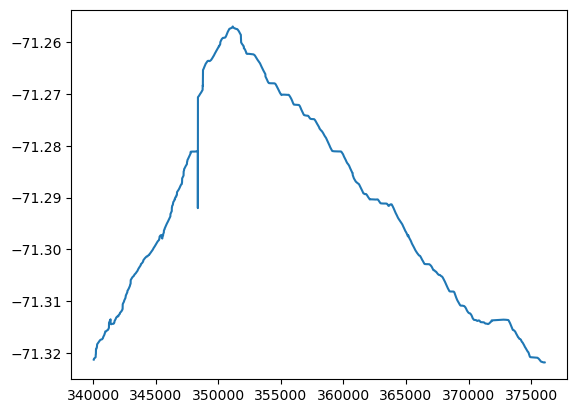

In [25]:
plt.plot(dirs[dirs['ParticipantID']==32].sort_values('date')['lon']) # East turnaround
#plt.plot(dirs[dirs['ParticipantID']==25].sort_values('date')['lon']) # West turnaround
#plt.plot(dirs[dirs['ParticipantID']==37].sort_values('date')['lon']) # One way eastbound
#plt.plot(dirs[dirs['ParticipantID']==36].sort_values('date')['lon']) # One way westbound

In [26]:
dirs = dirs.merge(combined_extremes, on='ParticipantID')

In [27]:
dirs['EB'] = 0 # assume westbound, overwrite if eastbound
dirs

,lon,date,ParticipantID,first_date,first_lon,last_date,last_lon,west_lon,west_date,east_lon,east_date,mid_lon,Turnaround,EB
0,-71.313876,2022-04-27T23:42:29.834Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
1,-71.313881,2022-04-27T23:42:29.938Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
2,-71.313887,2022-04-27T23:42:30.042Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
3,-71.313892,2022-04-27T23:42:30.146Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
4,-71.313898,2022-04-27T23:42:30.224Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,-71.256852,2022-09-23T18:31:05.106Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,0
408359,-71.256851,2022-09-23T18:31:05.222Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,0
408360,-71.256850,2022-09-23T18:31:05.337Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,0
408361,-71.256849,2022-09-23T18:31:05.420Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,0


In [28]:
dirs['EB'] = 0 # assume westbound, overwrite if eastbound
dirs.loc[dirs['Turnaround'] == 'One-Way Eastbound', 'EB'] = 1
dirs.loc[(dirs['Turnaround'] == 'East Turnaround') & (dirs['date'] < dirs['east_date']), 'EB'] = 1
dirs.loc[(dirs['Turnaround'] == 'West Turnaround') & (dirs['date'] > dirs['west_date']), 'EB'] = 1
dirs

,lon,date,ParticipantID,first_date,first_lon,last_date,last_lon,west_lon,west_date,east_lon,east_date,mid_lon,Turnaround,EB
0,-71.313876,2022-04-27T23:42:29.834Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
1,-71.313881,2022-04-27T23:42:29.938Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
2,-71.313887,2022-04-27T23:42:30.042Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
3,-71.313892,2022-04-27T23:42:30.146Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
4,-71.313898,2022-04-27T23:42:30.224Z,4,2022-04-27T23:42:29.834Z,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,-71.256852,2022-09-23T18:31:05.106Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1
408359,-71.256851,2022-09-23T18:31:05.222Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1
408360,-71.256850,2022-09-23T18:31:05.337Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1
408361,-71.256849,2022-09-23T18:31:05.420Z,37,2022-09-23T18:10:05.204Z,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1


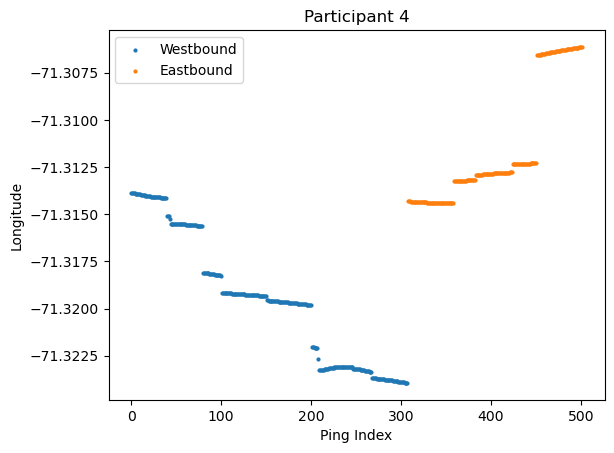

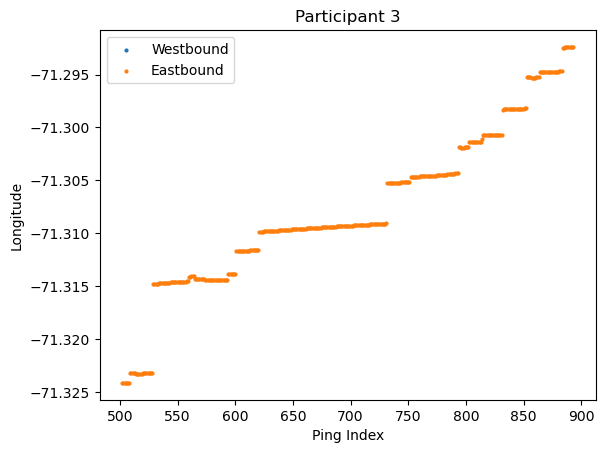

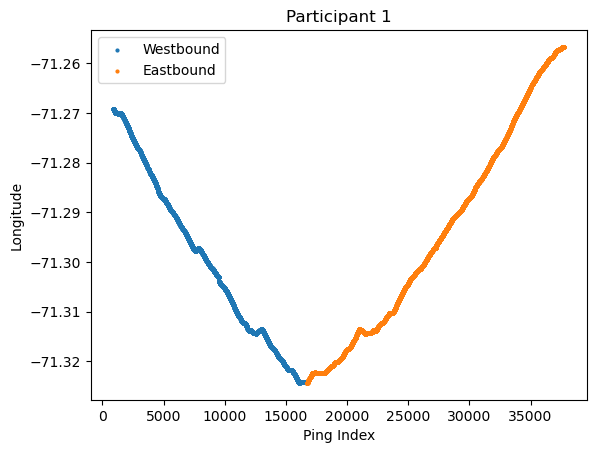

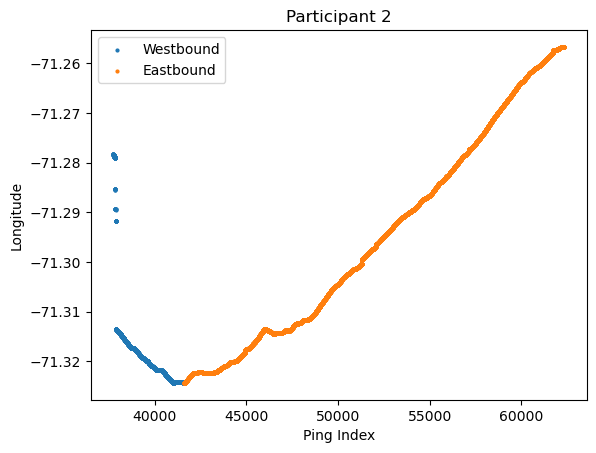

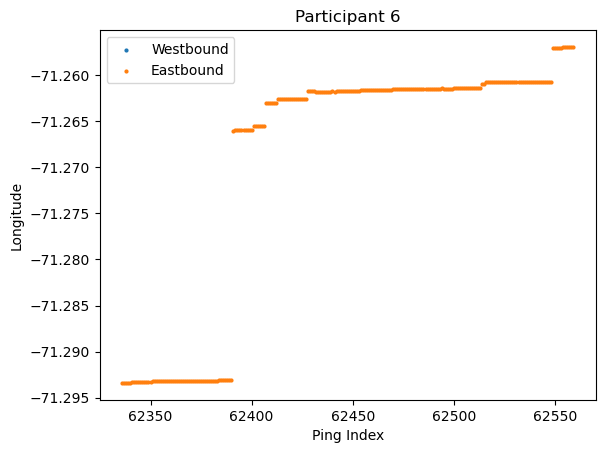

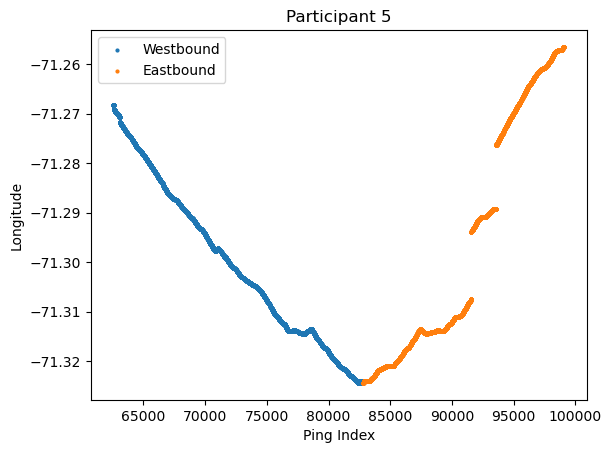

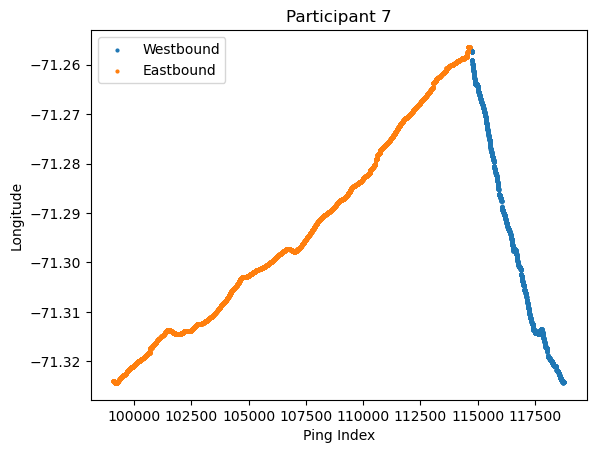

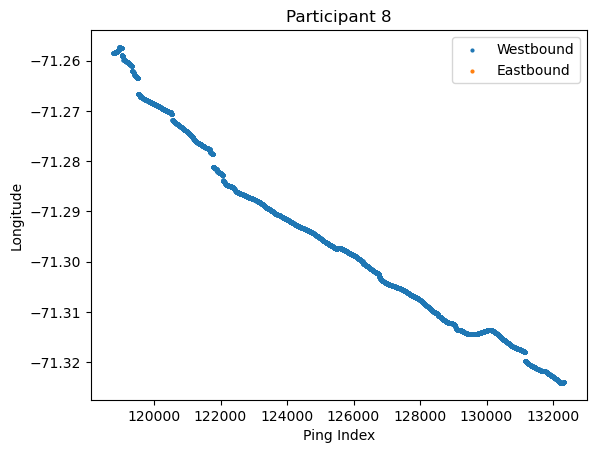

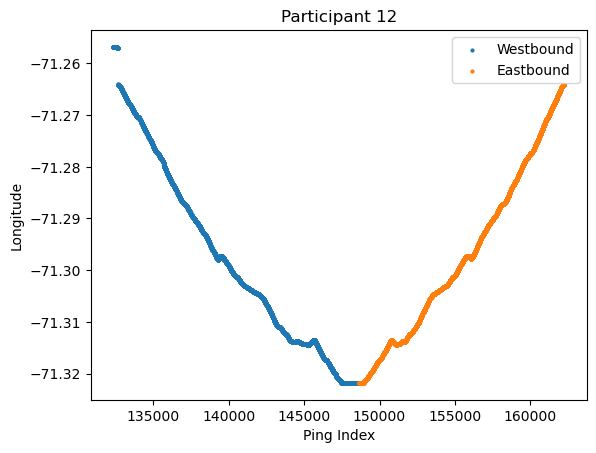

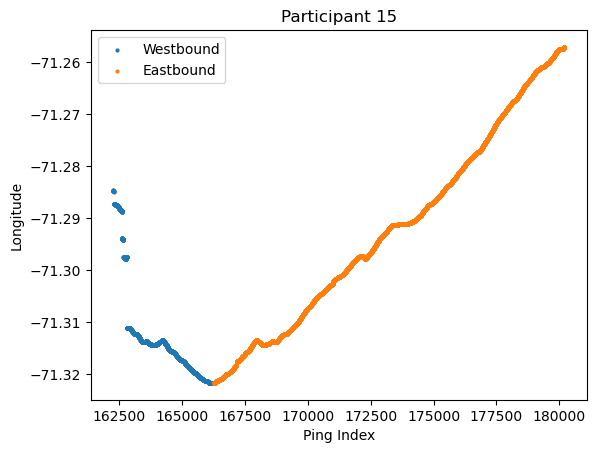

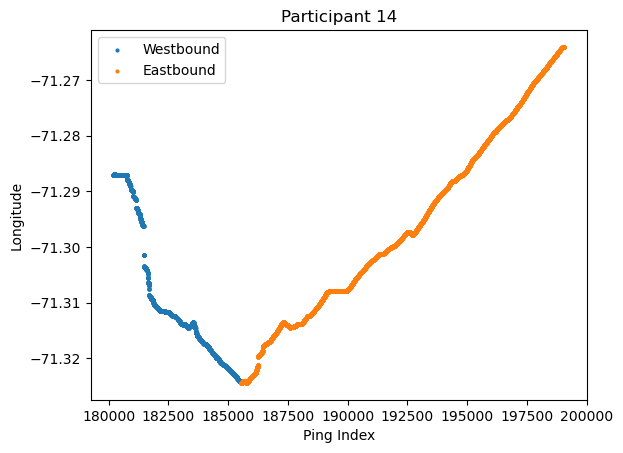

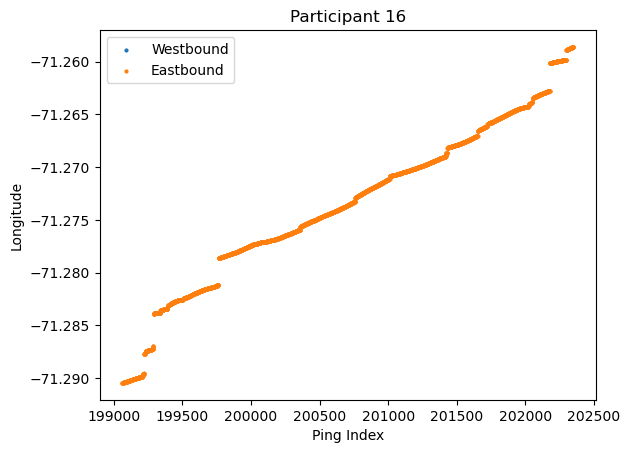

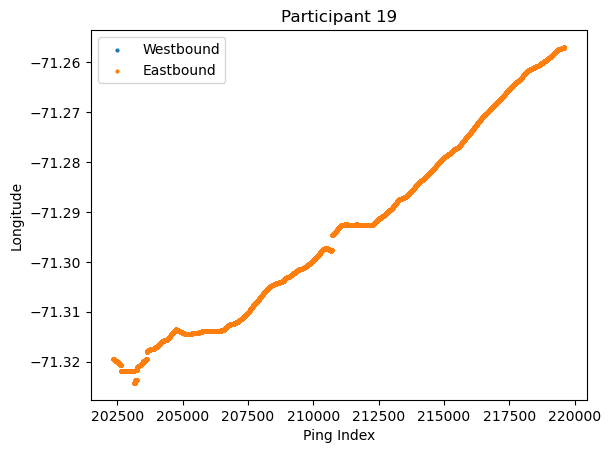

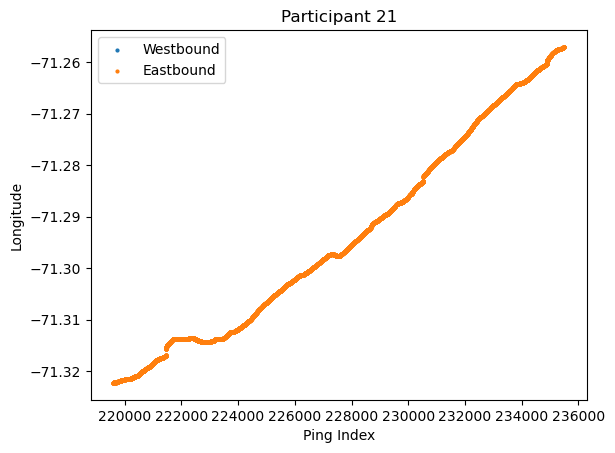

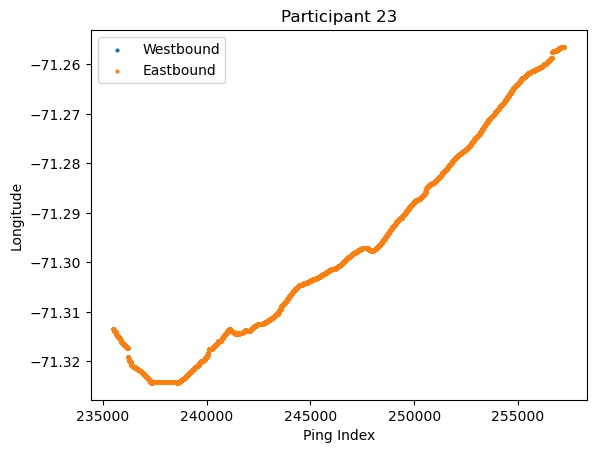

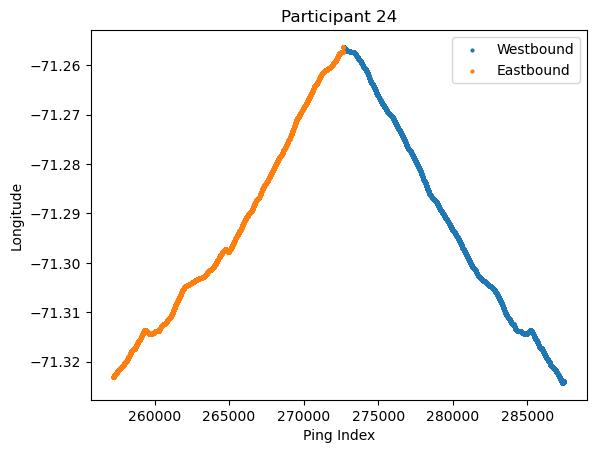

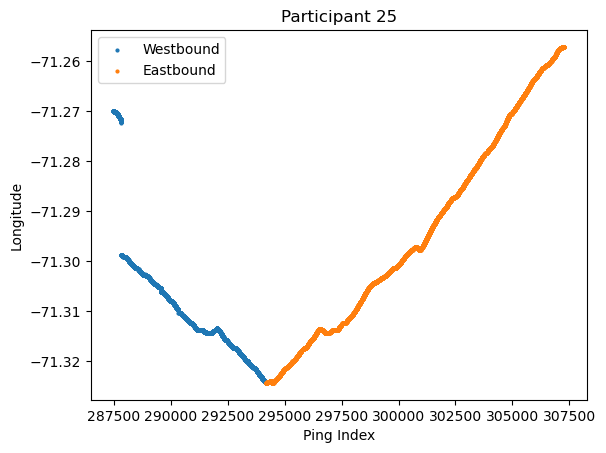

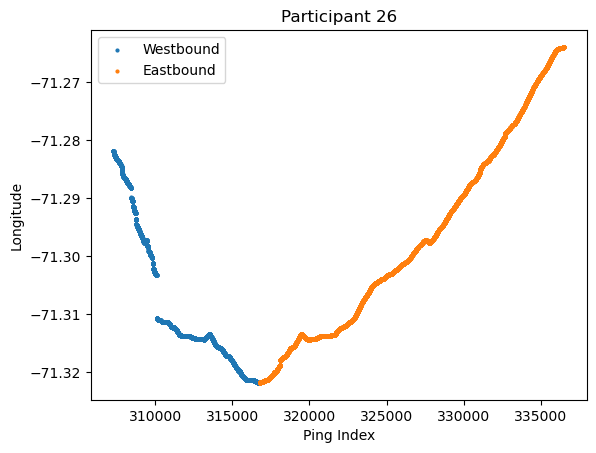

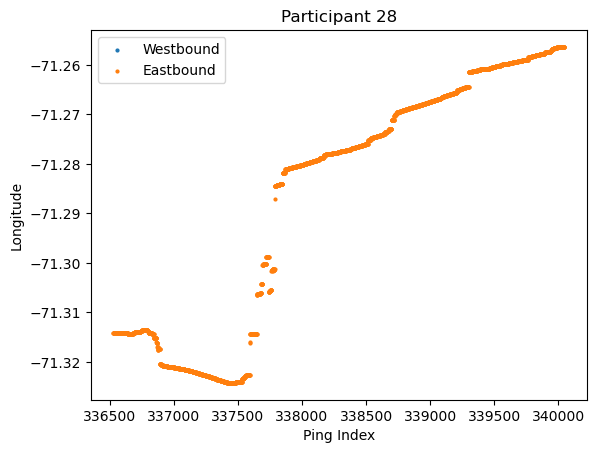

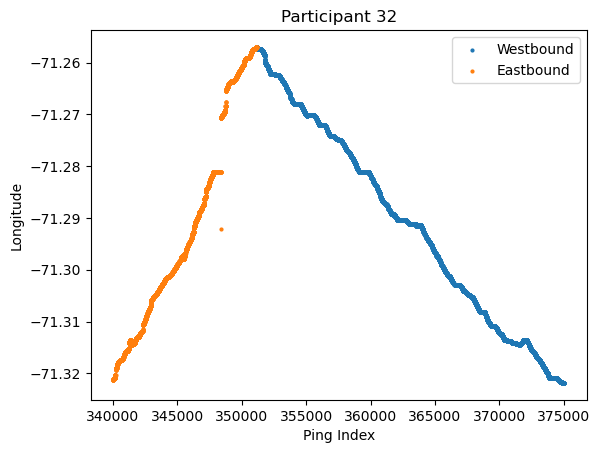

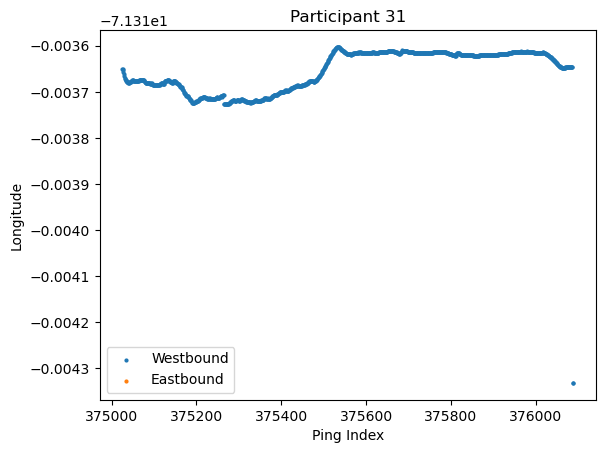

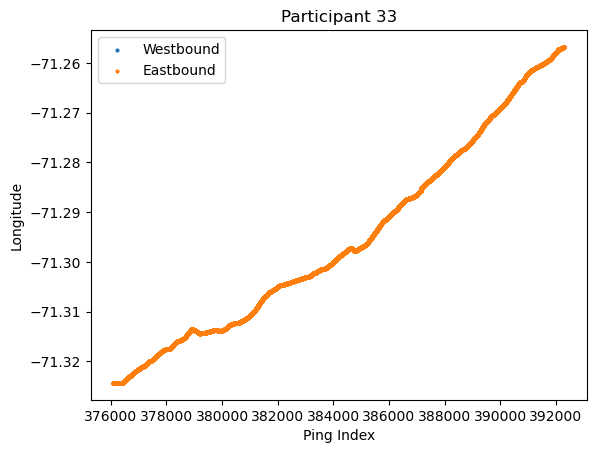

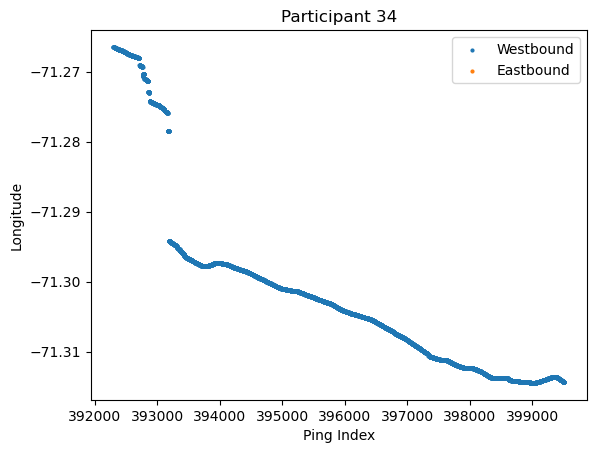

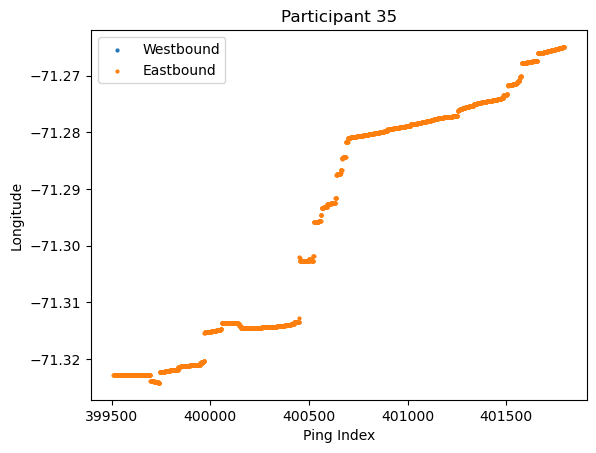

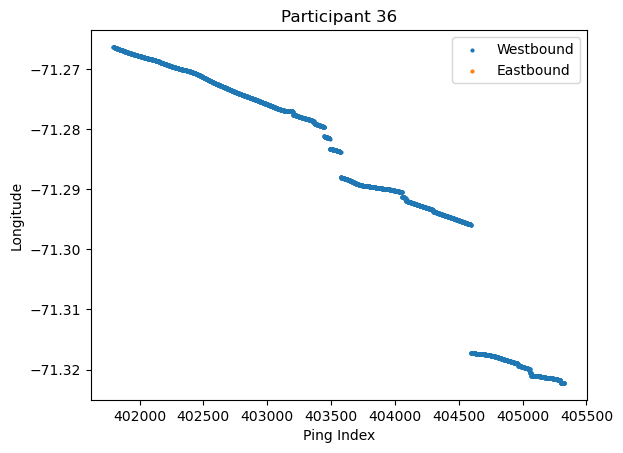

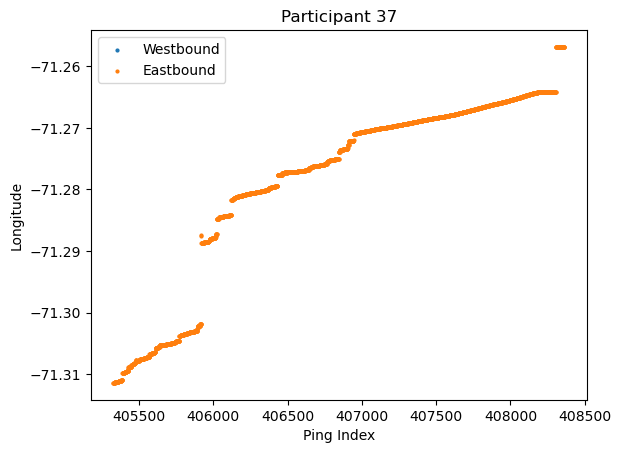

In [29]:
pid = 32 # East turnaround
#pid = 25 # West turnaround
#pid = 37 # One way eastbound
#pid = 36 # One way westbound

text = {0: 'Westbound', 1: 'Eastbound'}
for pid in dirs['ParticipantID'].unique():
    for eb in [0,1]:

        x = dirs.loc[(dirs['ParticipantID']==pid) & (dirs['EB']==eb)].index
        y = dirs.loc[(dirs['ParticipantID']==pid) & (dirs['EB']==eb), 'lon']
        plt.scatter(x, y, s=4, label=text[eb])
        plt.xlabel('Ping Index')
        plt.ylabel('Longitude')
        plt.title('Participant {}'.format(pid))
        plt.legend() # Eastbound = 1, westbound = 0
    plt.show()


In [132]:
#sns.FacetGrid()

In [45]:
gps_gdf

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,...,Slow Sign (WB),Trail Hazards,Trail Junction,Uphill (EB),Uphill (WB),Vehicle Conflict Point,Walk Bike Sign (WB),Wide Downhill (EB),Downhill (WB),Downhill (EB)
0,1.051038e+06,2022-04-27T23:42:29.834Z,42.459184,-71.313876,58.706562,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.051149e+06,2022-04-27T23:42:29.938Z,42.459187,-71.313881,58.707562,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.051261e+06,2022-04-27T23:42:30.042Z,42.459189,-71.313887,58.708062,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1.051372e+06,2022-04-27T23:42:30.146Z,42.459192,-71.313892,58.709062,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1.051455e+06,2022-04-27T23:42:30.224Z,42.459193,-71.313898,61.802062,4.9330,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,3.789637e+06,2022-09-23T18:31:05.106Z,42.447985,-71.256852,70.146000,1.3295,1.305,3,477.0,MSLV,...,0,0,0,0,0,0,0,0,0,0
408359,3.789755e+06,2022-09-23T18:31:05.222Z,42.447987,-71.256851,70.191500,1.3630,1.355,3,477.0,MSLV,...,0,0,0,0,0,0,0,0,0,0
408360,3.789869e+06,2022-09-23T18:31:05.337Z,42.447989,-71.256850,70.266000,1.3845,1.375,3,460.0,MSLV,...,0,0,0,0,0,0,0,0,0,0
408361,3.789948e+06,2022-09-23T18:31:05.420Z,42.447989,-71.256849,70.330000,1.3910,1.390,3,460.0,MSLV,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# merge back into main dataframe
gps_gdf_w_dirs = pd.merge(gps_gdf,dirs,left_index=True,right_index=True,suffixes=(None,"_y"), validate="one_to_one")
gps_gdf_w_dirs

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,...,first_lon,last_date,last_lon,west_lon,west_date,east_lon,east_date,mid_lon,Turnaround,EB
0,1.051038e+06,2022-04-27T23:42:29.834Z,42.459184,-71.313876,58.706562,4.7740,4.770,2,344.0,NaN,...,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
1,1.051149e+06,2022-04-27T23:42:29.938Z,42.459187,-71.313881,58.707562,4.7740,4.770,2,344.0,NaN,...,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
2,1.051261e+06,2022-04-27T23:42:30.042Z,42.459189,-71.313887,58.708062,4.7740,4.770,2,344.0,NaN,...,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
3,1.051372e+06,2022-04-27T23:42:30.146Z,42.459192,-71.313892,58.709062,4.7740,4.770,2,344.0,NaN,...,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
4,1.051455e+06,2022-04-27T23:42:30.224Z,42.459193,-71.313898,61.802062,4.9330,4.770,2,344.0,NaN,...,-71.313876,2022-04-27T23:54:07.375Z,-71.306132,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,3.789637e+06,2022-09-23T18:31:05.106Z,42.447985,-71.256852,70.146000,1.3295,1.305,3,477.0,MSLV,...,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1
408359,3.789755e+06,2022-09-23T18:31:05.222Z,42.447987,-71.256851,70.191500,1.3630,1.355,3,477.0,MSLV,...,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1
408360,3.789869e+06,2022-09-23T18:31:05.337Z,42.447989,-71.256850,70.266000,1.3845,1.375,3,460.0,MSLV,...,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1
408361,3.789948e+06,2022-09-23T18:31:05.420Z,42.447989,-71.256849,70.330000,1.3910,1.390,3,460.0,MSLV,...,-71.311435,2022-09-23T18:31:05.502Z,-71.256846,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1


In [57]:
gps_gdf_w_dirs.columns

Index(['cts', 'date', 'lat', 'lon', 'GPS (Alt.) [m]', 'GPS (2D speed) [m/s]',
       'spd', 'fix', 'precision', 'altitude system', 'participant',
       'ParticipantID', 'timestamp', 'geometry', 'Blind Turn',
       'Constrained Tunnel', 'Narrow', 'Slow Sign (EB)', 'Slow Sign (WB)',
       'Trail Hazards', 'Trail Junction', 'Uphill (EB)', 'Uphill (WB)',
       'Vehicle Conflict Point', 'Walk Bike Sign (WB)', 'Wide Downhill (EB)',
       'Downhill (WB)', 'Downhill (EB)', 'lon_y', 'date_y', 'ParticipantID_y',
       'first_date', 'first_lon', 'last_date', 'last_lon', 'west_lon',
       'west_date', 'east_lon', 'east_date', 'mid_lon', 'Turnaround', 'EB'],
      dtype='object')

In [58]:
# Slow sign EB and WB. Zero out wrong direction pings
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB'] == 1) & (gps_gdf_w_dirs['Slow Sign (WB)'] == 1), 'Slow Sign (WB)'] = 0 # b/c traveling EB
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB'] == 0) & (gps_gdf_w_dirs['Slow Sign (EB)'] == 1), 'Slow Sign (EB)'] = 0 # b/c traveling WB

# Walk Bike Sign WB. Zero out wrong direction pings
# Also, there is no matching EB column. Rename the WB column to a general Walk Bike Sign
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB'] == 1) & (gps_gdf_w_dirs['Walk Bike Sign (WB)'] == 1), 'Walk Bike Sign (WB)'] = 0 # b/c traveling EB
#gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB'] == 0) & (gps_gdf_w_dirs['Walk Bike Sign (EB)'] == 1), 'Walk Bike Sign (EB)'] = 0 # b/c traveling WB
gps_gdf_w_dirs = gps_gdf_w_dirs.rename(columns = {'Walk Bike Sign (WB)': 'Walk Bike Sign'})

# Combine uphill eb and wb into Uphill which is 1 if matching the direction of travel
gps_gdf_w_dirs['Uphill'] = 0
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB']==1) & (gps_gdf_w_dirs['Uphill (EB)'] == 1), 'Uphill'] = 1 # Set to 1 if Uphill (EB) and also EB direction
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB']==0) & (gps_gdf_w_dirs['Uphill (WB)'] == 1), 'Uphill'] = 1 # Set to 1 if Uphill (WB) = 1 and also WB direction

# Combine downhill eb and wb into Downhill which is 1 if matching the direction of travel
gps_gdf_w_dirs['Downhill'] = 0
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB']==1) & (gps_gdf_w_dirs['Downhill (EB)'] == 1), 'Downhill'] = 1 # Set to 1 if Downhill (EB) and also EB direction
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB']==0) & (gps_gdf_w_dirs['Downhill (WB)'] == 1), 'Downhill'] = 1 # Set to 1 if Downhill (WB) = 1 and also WB direction

# Combine slow sign eb and wb into Slow Sign which is 1 if matching the direction of travel
gps_gdf_w_dirs['Slow Sign'] = 0
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB']==1) & (gps_gdf_w_dirs['Slow Sign (EB)'] == 1), 'Slow Sign'] = 1 # Set to 1 if Slow Sign (EB) and also EB direction
gps_gdf_w_dirs.loc[(gps_gdf_w_dirs['EB']==0) & (gps_gdf_w_dirs['Slow Sign (WB)'] == 1), 'Slow Sign'] = 1 # Set to 1 if Slow Sign (WB) = 1 and also WB direction

gps_gdf_w_dirs

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,...,west_lon,west_date,east_lon,east_date,mid_lon,Turnaround,EB,Uphill,Downhill,Slow Sign
0,1.051038e+06,2022-04-27T23:42:29.834Z,42.459184,-71.313876,58.706562,4.7740,4.770,2,344.0,NaN,...,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0,0,0,0
1,1.051149e+06,2022-04-27T23:42:29.938Z,42.459187,-71.313881,58.707562,4.7740,4.770,2,344.0,NaN,...,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0,0,0,0
2,1.051261e+06,2022-04-27T23:42:30.042Z,42.459189,-71.313887,58.708062,4.7740,4.770,2,344.0,NaN,...,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0,0,0,0
3,1.051372e+06,2022-04-27T23:42:30.146Z,42.459192,-71.313892,58.709062,4.7740,4.770,2,344.0,NaN,...,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0,0,0,0
4,1.051455e+06,2022-04-27T23:42:30.224Z,42.459193,-71.313898,61.802062,4.9330,4.770,2,344.0,NaN,...,-71.323938,2022-04-27T23:45:45.860Z,-71.306132,2022-04-27T23:54:07.375Z,-71.315035,West Turnaround,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,3.789637e+06,2022-09-23T18:31:05.106Z,42.447985,-71.256852,70.146000,1.3295,1.305,3,477.0,MSLV,...,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1,0,0,0
408359,3.789755e+06,2022-09-23T18:31:05.222Z,42.447987,-71.256851,70.191500,1.3630,1.355,3,477.0,MSLV,...,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1,0,0,0
408360,3.789869e+06,2022-09-23T18:31:05.337Z,42.447989,-71.256850,70.266000,1.3845,1.375,3,460.0,MSLV,...,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1,0,0,0
408361,3.789948e+06,2022-09-23T18:31:05.420Z,42.447989,-71.256849,70.330000,1.3910,1.390,3,460.0,MSLV,...,-71.311435,2022-09-23T18:10:05.341Z,-71.256846,2022-09-23T18:31:05.502Z,-71.284141,One-Way Eastbound,1,0,0,0


In [59]:
# drop unneeded columns
gps_gdf_w_dirs = gps_gdf_w_dirs.drop(columns = ['Wide Downhill (EB)', 'Downhill (WB)', 'Downhill (EB)', 'Uphill (WB)', 'Uphill (EB)',
                               'first_lon','first_date','last_lon','last_date','west_lon',
                               'west_date','east_lon','east_date','mid_lon','Turnaround',
                                'lon_y', 'date_y', 'ParticipantID_y'])

gps_gdf_w_dirs

,cts,date,lat,lon,GPS (Alt.) [m],GPS (2D speed) [m/s],spd,fix,precision,altitude system,...,Slow Sign (EB),Slow Sign (WB),Trail Hazards,Trail Junction,Vehicle Conflict Point,Walk Bike Sign,EB,Uphill,Downhill,Slow Sign
0,1.051038e+06,2022-04-27T23:42:29.834Z,42.459184,-71.313876,58.706562,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.051149e+06,2022-04-27T23:42:29.938Z,42.459187,-71.313881,58.707562,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.051261e+06,2022-04-27T23:42:30.042Z,42.459189,-71.313887,58.708062,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1.051372e+06,2022-04-27T23:42:30.146Z,42.459192,-71.313892,58.709062,4.7740,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1.051455e+06,2022-04-27T23:42:30.224Z,42.459193,-71.313898,61.802062,4.9330,4.770,2,344.0,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408358,3.789637e+06,2022-09-23T18:31:05.106Z,42.447985,-71.256852,70.146000,1.3295,1.305,3,477.0,MSLV,...,0,0,0,0,0,0,1,0,0,0
408359,3.789755e+06,2022-09-23T18:31:05.222Z,42.447987,-71.256851,70.191500,1.3630,1.355,3,477.0,MSLV,...,0,0,0,0,0,0,1,0,0,0
408360,3.789869e+06,2022-09-23T18:31:05.337Z,42.447989,-71.256850,70.266000,1.3845,1.375,3,460.0,MSLV,...,0,0,0,0,0,0,1,0,0,0
408361,3.789948e+06,2022-09-23T18:31:05.420Z,42.447989,-71.256849,70.330000,1.3910,1.390,3,460.0,MSLV,...,0,0,0,0,0,0,1,0,0,0


In [60]:
gps_gdf_w_dirs.sort_values(["ParticipantID", "date"]).to_csv(os.path.join(data_dir, "Pings_Tagged_w_Dir_2023-07-09.csv"), index=False)

In [61]:
counts = gps_gdf_w_dirs.groupby('ParticipantID')['Blind Turn','Constrained Tunnel','Narrow','Slow Sign (EB)','Slow Sign (WB)',
                                       'Trail Hazards','Trail Junction','Vehicle Conflict Point', 'Walk Bike Sign','EB',
                                       'Uphill', 'Downhill'].sum().reset_index()
counts.to_csv(os.path.join(data_dir, "Pings_Tagged_w_Dir_COUNTS_2023-07-09.csv"), index=False)
counts

C:\Users\ian.berg\AppData\Local\Temp\ipykernel_16552\4131720848.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  counts = gps_gdf_w_dirs.groupby('ParticipantID')['Blind Turn','Constrained Tunnel','Narrow','Slow Sign (EB)','Slow Sign (WB)',


,ParticipantID,Blind Turn,Constrained Tunnel,Narrow,Slow Sign (EB),Slow Sign (WB),Trail Hazards,Trail Junction,Vehicle Conflict Point,Walk Bike Sign,EB,Uphill,Downhill
0,1,2914,144,4092,225,218,3428,1246,1916,115,20916,5290,8268
1,2,1772,139,2699,276,132,2022,653,1560,0,20813,2206,4988
2,3,16,0,17,0,0,25,20,20,0,392,86,72
3,4,0,0,28,0,0,51,0,0,0,194,92,51
4,5,3091,94,6074,0,125,2352,1406,2182,153,16312,5926,7079
5,6,0,0,0,0,0,10,54,23,0,224,0,55
6,7,1290,51,1916,153,19,2068,554,1045,21,15415,4389,3044
7,8,1109,76,1420,0,77,1398,470,369,81,134,3487,2398
8,12,2498,188,6717,200,96,2881,1040,1626,191,13592,6649,6602
9,14,1526,86,2127,175,0,1488,612,1133,83,13511,3684,4398
